# 🔧 Feature Engineering — Parte 2

**Objetivo:** Criar features avançadas e features derivadas de modelagem (scorecard e faixa de risco).

**Fluxo conceitual:**
```
Parte 1 (05)                    Parte 2 (este notebook)
─────────────────               ──────────────────────────────────────────────
Features brutas          →      Binning / Interações / Flags / Polinomiais
WOE/IV seleção           →      Agregações
                         →      Pipeline LogReg + Scorecard PDO
                         →      score + faixa_risco  (features derivadas)
                         →      Validação + IV + Exportação
```

**Seções:**
1. Setup e Carregamento
2. Binning de Variáveis Contínuas
3. Features de Interação
4. Flags Booleanas Avançadas
5. Features Polinomiais
6. Features de Agregação
7. Pipeline de Modelagem — Scorecard
8. Calibração PDO e Score Final
9. `faixa_risco` — Feature Derivada do Score
10. Validação das Features Derivadas
11. Cálculo de IV — Todas as Novas Features
12. Exportação

## 1. Setup e Carregamento

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import sys
import warnings

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
sys.path.append('../src')
from feature_engineering import calc_woe_iv

# ── Configurações globais ──────────────────────────────────────────────────────
TARGET_COL    = 'inadipl_90dias_ult2anos'
INPUT_PT1     = '../data/features/df_features_selected.csv'
OUTPUT_PT2    = '../data/features/df_features_pt2.csv'
OUTPUT_MODEL  = '../outputs/models'
OUTPUT_WOE    = '../outputs/woe_iv'
IV_THRESHOLD  = 0.05
PDO           = 50       # Points to Double the Odds
BASE_SCORE    = 600      # Score base de referência
SALARIO_MIN   = 1412     # Salário mínimo 2026

os.makedirs(OUTPUT_MODEL, exist_ok=True)
os.makedirs(OUTPUT_WOE,   exist_ok=True)
os.makedirs(os.path.dirname(OUTPUT_PT2), exist_ok=True)

# ── Carregamento ───────────────────────────────────────────────────────────────
df_fe = pd.read_csv(INPUT_PT1)
X     = df_fe.drop(columns=[TARGET_COL])
y     = df_fe[TARGET_COL]

print("=" * 70)
print("🔧 FEATURE ENGINEERING — PARTE 2")
print("=" * 70)
print(f"  Shape inicial (Parte 1): {df_fe.shape}")

# Identificar tipos de variáveis
numeric_features     = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"  Numéricas   : {len(numeric_features)}")
print(f"  Categóricas : {len(categorical_features)}")

🔧 FEATURE ENGINEERING — PARTE 2
  Shape inicial (Parte 1): (149234, 27)
  Numéricas   : 26
  Categóricas : 0


## 2. Binning de Variáveis Contínuas

Transforma variáveis numéricas em categorias ordinais usando três estratégias:
- **Quantis** (`pd.qcut`): divisão com igual número de registros por faixa
- **Bins de negócio** (`pd.cut`): cortes baseados em regras do domínio financeiro
- **KBinsDiscretizer**: binning automático por quantil via sklearn

In [16]:
print("=" * 70)
print("📊 BINNING DE VARIÁVEIS CONTÍNUAS")
print("=" * 70)

# ── Renda mensal — por quantis ────────────────────────────────────────────────
if 'renda_mensal' in df_fe.columns:
    df_fe['renda_mensal_quantil'] = pd.qcut(
        df_fe['renda_mensal'],
        q=5,
        labels=['Q1_Muito_Baixa', 'Q2_Baixa', 'Q3_Media', 'Q4_Alta', 'Q5_Muito_Alta'],
        duplicates='drop'
    )
    print("✅ renda_mensal_quantil criada (5 quantis)")

    # Por faixas de salário mínimo
    df_fe['renda_faixa_sm'] = pd.cut(
        df_fe['renda_mensal'],
        bins=[0, SALARIO_MIN, SALARIO_MIN*2, SALARIO_MIN*4, SALARIO_MIN*8, float('inf')],
        labels=['Ate_1SM', '1_2SM', '2_4SM', '4_8SM', 'Acima_8SM'],
        include_lowest=True
    )
    print(f"✅ renda_faixa_sm criada (SM = R$ {SALARIO_MIN})")

# ── Idade — por geração ───────────────────────────────────────────────────────
if 'idade' in df_fe.columns:
    df_fe['geracao'] = pd.cut(
        df_fe['idade'],
        bins=[0, 25, 40, 55, 70, 100],
        labels=['Gen_Z', 'Millennial', 'Gen_X', 'Baby_Boomer', 'Silent'],
        include_lowest=True
    )
    print("✅ geracao criada")

# ── Utilização de crédito — KBinsDiscretizer ──────────────────────────────────
if 'utilizacao_credito' in df_fe.columns:
    _disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    df_fe['utilizacao_credito_bin'] = _disc.fit_transform(
        df_fe[['utilizacao_credito']]
    ).astype(int)
    print("✅ utilizacao_credito_bin criada (KBins — 4 faixas por quantil)")

print(f"\n   Shape atual: {df_fe.shape}")

📊 BINNING DE VARIÁVEIS CONTÍNUAS
✅ renda_mensal_quantil criada (5 quantis)
✅ renda_faixa_sm criada (SM = R$ 1412)
✅ geracao criada
✅ utilizacao_credito_bin criada (KBins — 4 faixas por quantil)

   Shape atual: (149234, 31)


## 3. Features de Interação

Captura efeitos combinados entre variáveis que individualmente têm poder preditivo médio, mas juntas revelam padrões de risco mais precisos.

In [17]:
print("=" * 70)
print("🔗 FEATURES DE INTERAÇÃO")
print("=" * 70)

# ── Idade × Renda ─────────────────────────────────────────────────────────────
if all(c in df_fe.columns for c in ['idade', 'renda_mensal']):
    df_fe['interacao_idade_renda'] = df_fe['idade'] * df_fe['renda_mensal'] / 1000
    print("✅ interacao_idade_renda criada")

# ── Atrasos × Utilização de crédito ──────────────────────────────────────────
if all(c in df_fe.columns for c in ['total_atrasos', 'utilizacao_credito']):
    df_fe['interacao_atrasos_utilizacao'] = (
        df_fe['total_atrasos'] * df_fe['utilizacao_credito']
    )
    print("✅ interacao_atrasos_utilizacao criada")

# ── Dívida × Linhas de crédito ────────────────────────────────────────────────
if all(c in df_fe.columns for c in ['divida_ratio', 'linhas_credito_abertas']):
    df_fe['interacao_divida_linhas'] = (
        df_fe['divida_ratio'] * df_fe['linhas_credito_abertas']
    )
    print("✅ interacao_divida_linhas criada")

# ── Pressão familiar: dependentes vs renda ────────────────────────────────────
if all(c in df_fe.columns for c in ['renda_mensal', 'dependentes']):
    df_fe['pressao_dependentes_renda'] = (
        df_fe['dependentes'] / (df_fe['renda_mensal'] / 1000 + 1)
    )
    print("✅ pressao_dependentes_renda criada")

print(f"\n   Shape atual: {df_fe.shape}")

🔗 FEATURES DE INTERAÇÃO
✅ interacao_idade_renda criada
✅ interacao_divida_linhas criada
✅ pressao_dependentes_renda criada

   Shape atual: (149234, 34)


## 4. Flags Booleanas Avançadas

Flags compostas que sintetizam múltiplas condições de risco em um único indicador.

In [18]:
print("=" * 70)
print("🚩 FLAGS BOOLEANAS AVANÇADAS")
print("=" * 70)

# ── Flag de alto risco (2+ condições simultâneas) ─────────────────────────────
condicoes_risco = []
if 'total_atrasos'       in df_fe.columns: condicoes_risco.append(df_fe['total_atrasos'] > 3)
if 'divida_ratio'        in df_fe.columns: condicoes_risco.append(df_fe['divida_ratio'] > 0.6)
if 'utilizacao_credito'  in df_fe.columns: condicoes_risco.append(df_fe['utilizacao_credito'] > 0.9)

if condicoes_risco:
    df_fe['flag_alto_risco'] = (sum(condicoes_risco) >= 2).astype(int)
    print(f"✅ flag_alto_risco criada  ({df_fe['flag_alto_risco'].mean()*100:.1f}% da base)")

# ── Flag de cliente estável (todas as condições verdadeiras) ──────────────────
condicoes_estabilidade = []
if 'idade'        in df_fe.columns: condicoes_estabilidade.append(df_fe['idade'] > 35)
if 'renda_mensal' in df_fe.columns: condicoes_estabilidade.append(df_fe['renda_mensal'] > df_fe['renda_mensal'].median())
if 'total_atrasos'in df_fe.columns: condicoes_estabilidade.append(df_fe['total_atrasos'] == 0)

if condicoes_estabilidade:
    df_fe['flag_cliente_estavel'] = (
        sum(condicoes_estabilidade) == len(condicoes_estabilidade)
    ).astype(int)
    print(f"✅ flag_cliente_estavel criada  ({df_fe['flag_cliente_estavel'].mean()*100:.1f}% da base)")

# ── Flag de thin file (histórico escasso) ────────────────────────────────────
if 'linhas_credito_abertas' in df_fe.columns:
    df_fe['flag_thin_file'] = (df_fe['linhas_credito_abertas'] <= 2).astype(int)
    print(f"✅ flag_thin_file criada  ({df_fe['flag_thin_file'].mean()*100:.1f}% da base)")

# ── Flag de imóvel (ativo de garantia) ───────────────────────────────────────
if 'emprestimos_imobiliarioss' in df_fe.columns:
    df_fe['flag_possui_imovel'] = (df_fe['emprestimos_imobiliarioss'] > 0).astype(int)
    print(f"✅ flag_possui_imovel criada  ({df_fe['flag_possui_imovel'].mean()*100:.1f}% da base)")

print(f"\n   Shape atual: {df_fe.shape}")

🚩 FLAGS BOOLEANAS AVANÇADAS
✅ flag_alto_risco criada  (4.3% da base)
✅ flag_cliente_estavel criada  (46.7% da base)
✅ flag_thin_file criada  (8.3% da base)
✅ flag_possui_imovel criada  (62.9% da base)

   Shape atual: (149234, 38)


## 5. Features Polinomiais

Transformações não-lineares para capturar relações curvilíneas.

> ⚠️ **Multicolinearidade:** `idade` e `idade_quadrado` são altamente correlacionadas. A centralização reduz esse efeito. Para modelos baseados em árvore (XGBoost, RF), essas features são desnecessárias.

In [19]:
print("=" * 70)
print("📐 FEATURES POLINOMIAIS")
print("=" * 70)

# ── Idade centralizada + quadrado ─────────────────────────────────────────────
# Centralizar antes de elevar reduz multicolinearidade com 'idade'
if 'idade' in df_fe.columns:
    _media_idade            = df_fe['idade'].mean()
    df_fe['idade_centralizada'] = df_fe['idade'] - _media_idade
    df_fe['idade_quadrado']     = df_fe['idade_centralizada'] ** 2
    df_fe['idade_raiz']         = np.sqrt(df_fe['idade'])
    print(f"✅ idade_quadrado criada  (centralizada em {_media_idade:.1f} anos)")
    print("✅ idade_raiz criada")

# ── Log de renda (normaliza distribuição assimétrica) ────────────────────────
if 'renda_mensal' in df_fe.columns:
    df_fe['log_renda_mensal'] = np.log1p(df_fe['renda_mensal'])
    print("✅ log_renda_mensal criada  (log1p — evita log(0))")

# ── Utilização ao quadrado (penaliza uso extremo do limite) ──────────────────
if 'utilizacao_credito' in df_fe.columns:
    df_fe['utilizacao_credito_quadrado'] = df_fe['utilizacao_credito'] ** 2
    print("✅ utilizacao_credito_quadrado criada")

print(f"\n   Shape atual: {df_fe.shape}")

📐 FEATURES POLINOMIAIS
✅ idade_quadrado criada  (centralizada em 52.3 anos)
✅ idade_raiz criada
✅ log_renda_mensal criada  (log1p — evita log(0))
✅ utilizacao_credito_quadrado criada

   Shape atual: (149234, 43)


## 6. Features de Agregação

Scores compostos que combinam múltiplas variáveis em índices sintéticos de comportamento financeiro.

In [20]:
print("=" * 70)
print("📊 FEATURES DE AGREGAÇÃO")
print("=" * 70)

# ── Score ponderado de atrasos ────────────────────────────────────────────────
DELAY_COLS  = [c for c in ['atrasos_30dias', 'atrasos_90dias'] if c in df_fe.columns]
DELAY_PESOS = {'atrasos_30dias': 1, 'atrasos_90dias': 3}

if DELAY_COLS:
    soma_pond = sum(df_fe[c] * DELAY_PESOS[c] for c in DELAY_COLS)
    soma_peso = sum(DELAY_PESOS[c] for c in DELAY_COLS)
    df_fe['score_ponderado_atrasos'] = soma_pond / soma_peso
    print(f"✅ score_ponderado_atrasos criada  (colunas: {DELAY_COLS})")

# ── Índice de pressão financeira ─────────────────────────────────────────────
COLS_PRESSAO = [c for c in ['divida_ratio', 'utilizacao_credito'] if c in df_fe.columns]
if COLS_PRESSAO:
    df_fe['indice_pressao_financeira'] = df_fe[COLS_PRESSAO].mean(axis=1)
    print(f"✅ indice_pressao_financeira criada  (componentes: {COLS_PRESSAO})")

print(f"\n   Shape atual: {df_fe.shape}")

📊 FEATURES DE AGREGAÇÃO
✅ score_ponderado_atrasos criada  (colunas: ['atrasos_30dias', 'atrasos_90dias'])
✅ indice_pressao_financeira criada  (componentes: ['divida_ratio', 'utilizacao_credito'])

   Shape atual: (149234, 45)


## 7. Pipeline de Modelagem — Scorecard

Treina uma Regressão Logística sobre as features selecionadas e converte os coeficientes em pontos de scorecard (escala 300–900).

> **Por que aqui?** `score` e `faixa_risco` são features derivadas do modelo, não features brutas. Elas pertencem ao Feature Engineering porque serão usadas como inputs em análises downstream (dashboard, relatórios) — não substituem o pipeline de modelagem final.

In [38]:

# Colunas que o modelo conhece
cols_modelo = X_model.columns.tolist()

# Colunas disponíveis no df_fe (interseção)
cols_disponiveis = [c for c in cols_modelo if c in df_fe.columns]
cols_faltando    = [c for c in cols_modelo if c not in df_fe.columns]

print(f"  Colunas no modelo  : {len(cols_modelo)}")
print(f"  Disponíveis no df_fe: {len(cols_disponiveis)}")
print(f"  Faltando no df_fe  : {cols_faltando}")

# Criar imputer próprio para o df_fe (não reusa o do pipeline)
imputer_pred   = SimpleImputer(strategy='median')
X_pred_imputed = imputer_pred.fit_transform(df_fe[cols_disponiveis])

# Criar novo modelo treinado apenas com as colunas disponíveis
# (não usa o pipeline original que foi treinado com colunas diferentes)
modelo_pred = LogisticRegression(max_iter=1000, random_state=42)
modelo_pred.fit(
    imputer_pred.fit_transform(X_model[cols_disponiveis]),
    y_model
)

y_pred_proba_raw = modelo_pred.predict_proba(X_pred_imputed)[:, 1]

# Verificar métricas com as colunas em comum
auc_pred = roc_auc_score(df_fe[TARGET_COL], y_pred_proba_raw)
print(f"\n  AUC com colunas disponíveis: {auc_pred:.4f}")

  Colunas no modelo  : 19
  Disponíveis no df_fe: 18
  Faltando no df_fe  : ['faixa_etaria_num']

  AUC com colunas disponíveis: 0.8012


In [44]:
# ── Pipeline definitivo — 18 colunas sem faixa_etaria_num ────────────────────
cols_modelo      = X_model.columns.tolist()
cols_disponiveis = [
    c for c in cols_modelo
    if c in df_fe.columns and c != 'faixa_etaria_num'  # removida por multicolinearidade com idade
]

imputer_pred     = SimpleImputer(strategy='median')
X_train          = imputer_pred.fit_transform(X_model[cols_disponiveis])
X_pred           = imputer_pred.transform(df_fe[cols_disponiveis])

modelo_pred      = LogisticRegression(max_iter=1000, random_state=42)
modelo_pred.fit(X_train, y_model)
y_pred_proba_raw = modelo_pred.predict_proba(X_pred)[:, 1]

# ── Métricas finais ───────────────────────────────────────────────────────────
auc  = roc_auc_score(df_fe[TARGET_COL], y_pred_proba_raw)
gini = 2 * auc - 1
ks   = ks_stat(df_fe[TARGET_COL], y_pred_proba_raw)

print(f"  Features utilizadas : {len(cols_disponiveis)}")
print(f"  AUC                 : {auc:.4f}")
print(f"  Gini                : {gini:.4f}")
print(f"  KS                  : {ks:.4f}")

# ── Persistência ──────────────────────────────────────────────────────────────
joblib.dump(modelo_pred,  os.path.join(OUTPUT_MODEL, 'log_reg_modelo.pkl'))
joblib.dump(imputer_pred, os.path.join(OUTPUT_MODEL, 'imputer_pred.pkl'))
joblib.dump(cols_disponiveis, os.path.join(OUTPUT_MODEL, 'cols_modelo.pkl'))
print("✅ Modelo, imputer e lista de colunas salvos")

  Features utilizadas : 18
  AUC                 : 0.8012
  Gini                : 0.6024
  KS                  : 0.4751
✅ Modelo, imputer e lista de colunas salvos


## 8. Calibração PDO e Score Final

Converte as probabilidades do modelo em uma escala de score (300–900) usando a metodologia padrão de mercado:

```
Score = Offset + Factor × log(odds)
Factor = PDO / log(2)
Offset = BaseScore - Factor × log(odds_real_da_base)
```

**PDO (Points to Double the Odds):** a cada 50 pontos a mais no score, os odds de ser bom pagador dobram.

In [45]:
print("=" * 70)
print("📐 CALIBRAÇÃO PDO — SCORE FINAL")
print("=" * 70)

# ── Odds reais da base ────────────────────────────────────────────────────────
taxa_inad  = y_model.mean()
odds_real  = (1 - taxa_inad) / taxa_inad

print(f"  Taxa de inadimplência : {taxa_inad:.4f} ({taxa_inad*100:.2f}%)")
print(f"  Odds reais da base    : {odds_real:.4f}")

# ── Parâmetros PDO ────────────────────────────────────────────────────────────
Factor = PDO / np.log(2)
Offset = BASE_SCORE - Factor * np.log(odds_real)

print(f"\n  PDO        : {PDO}")
print(f"  Base Score : {BASE_SCORE}")
print(f"  Factor     : {Factor:.4f}")
print(f"  Offset     : {Offset:.4f}")

# ── Função de conversão ───────────────────────────────────────────────────────
def prob_to_score(prob: float, offset: float, factor: float) -> float:
    """
    Converte probabilidade de inadimplência em score (300–900).

    Parâmetros
    ----------
    prob   : probabilidade de inadimplência (entre 0 e 1)
    offset : parâmetro de calibração PDO
    factor : parâmetro de escala PDO

    Retorna
    -------
    score numérico
    """
    odds = (1 - prob) / prob
    return offset + factor * np.log(odds)

# Clip para evitar log(0) ou log(inf)
EPS = 1e-6
y_pred_proba_adj = np.clip(y_pred_proba_raw, EPS, 1 - EPS)

df_fe['score'] = [prob_to_score(p, Offset, Factor) for p in y_pred_proba_adj]

print(f"\n✅ score criado")
print(df_fe['score'].describe().round(2).to_string())

📐 CALIBRAÇÃO PDO — SCORE FINAL
  Taxa de inadimplência : 0.0671 (6.71%)
  Odds reais da base    : 13.9115

  PDO        : 50
  Base Score : 600
  Factor     : 72.1348
  Offset     : 410.0898

✅ score criado
count    149234.00
mean        635.16
std          75.97
min        -586.49
25%         588.26
50%         653.19
75%         690.54
max        1406.67


## 9. `faixa_risco` — Feature Derivada do Score

Classifica o score em faixas balanceadas usando quantis reais da distribuição, garantindo aproximadamente igual número de clientes em cada faixa.

In [46]:
print("=" * 70)
print("🏷️  FAIXA DE RISCO — FEATURE DERIVADA")
print("=" * 70)

# ── Classificação por quantis reais (evita faixas vazias) ─────────────────────
p33 = df_fe['score'].quantile(0.33)
p66 = df_fe['score'].quantile(0.66)

def classify_risk(score: float) -> str:
    """Classifica o score em faixa de risco por quantis (p33 / p66)."""
    if score >= p66:
        return 'Baixo Risco'
    elif score >= p33:
        return 'Médio Risco'
    else:
        return 'Alto Risco'

df_fe['faixa_risco'] = df_fe['score'].apply(classify_risk)

print(f"  Limiar p33 (Alto → Médio) : {p33:.2f}")
print(f"  Limiar p66 (Médio → Baixo): {p66:.2f}")
print(f"\n  Distribuição por faixa:")
print(df_fe['faixa_risco'].value_counts().to_string())
print(f"\n✅ faixa_risco criada")

🏷️  FAIXA DE RISCO — FEATURE DERIVADA
  Limiar p33 (Alto → Médio) : 615.12
  Limiar p66 (Médio → Baixo): 677.72

  Distribuição por faixa:
faixa_risco
Baixo Risco    50740
Alto Risco     49247
Médio Risco    49247

✅ faixa_risco criada


## 10. Validação das Features Derivadas

Verifica se `score` e `faixa_risco` são consistentes com a inadimplência real — a condição mínima para usá-las como features.

✅ VALIDAÇÃO DAS FEATURES DERIVADAS

📊 Taxa de inadimplência por faixa:
faixa_risco
Alto Risco     0.156233
Médio Risco    0.032611
Baixo Risco    0.013953

  ✅ Consistente se: Alto Risco > Médio Risco > Baixo Risco


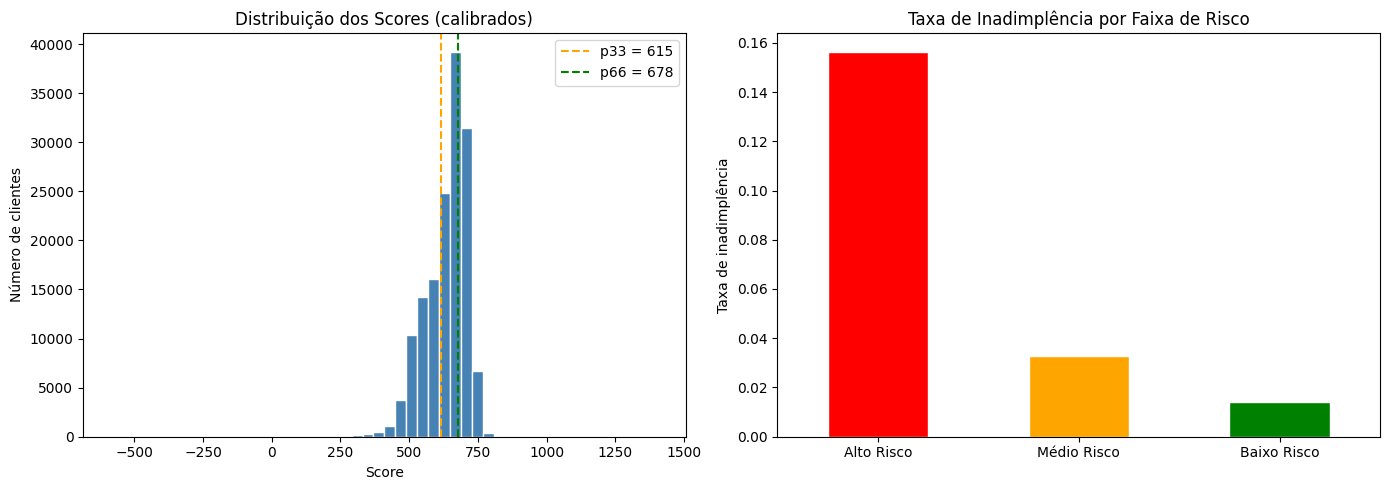

In [47]:
print("=" * 70)
print("✅ VALIDAÇÃO DAS FEATURES DERIVADAS")
print("=" * 70)

# ── Taxa de inadimplência por faixa de risco ──────────────────────────────────
taxa_por_faixa = (
    df_fe.groupby('faixa_risco')[TARGET_COL]
    .mean()
    .sort_values(ascending=False)
)
print("\n📊 Taxa de inadimplência por faixa:")
print(taxa_por_faixa.to_string())
print("\n  ✅ Consistente se: Alto Risco > Médio Risco > Baixo Risco")

# ── Distribuição do score ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_fe['score'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribuição dos Scores (calibrados)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Número de clientes')
axes[0].axvline(p33, color='orange', linestyle='--', label=f'p33 = {p33:.0f}')
axes[0].axvline(p66, color='green',  linestyle='--', label=f'p66 = {p66:.0f}')
axes[0].legend()

cores = {'Alto Risco': 'red', 'Médio Risco': 'orange', 'Baixo Risco': 'green'}
taxa_por_faixa_plot = taxa_por_faixa.reindex(['Alto Risco', 'Médio Risco', 'Baixo Risco'])
taxa_por_faixa_plot.plot(
    kind='bar',
    ax=axes[1],
    color=[cores[f] for f in taxa_por_faixa_plot.index],
    edgecolor='white'
)
axes[1].set_title('Taxa de Inadimplência por Faixa de Risco')
axes[1].set_ylabel('Taxa de inadimplência')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 11. Cálculo de IV — Todas as Novas Features

Calcula o Information Value para todas as features criadas nesta parte e consolida o ranking.

In [48]:
def calc_iv_batch(df, var_bins_dict, target):
    """Calcula IV para um dicionário {variável: bins}."""
    results = {}
    for var, bins in var_bins_dict.items():
        if var not in df.columns or bins is None:
            continue
        try:
            _, iv = calc_woe_iv(df, var, target, bins)
            results[var] = iv
            print(f"  ✅ {var:<45} IV = {iv:.4f}")
        except Exception as e:
            print(f"  ⚠️  {var:<45} Erro: {e}")
    return results


print("=" * 70)
print("📊 IV — TODAS AS NOVAS FEATURES")
print("=" * 70)

# ── Score (feature derivada) ──────────────────────────────────────────────────
_q25_sc = df_fe['score'].quantile(0.25)
_q50_sc = df_fe['score'].quantile(0.50)
_q75_sc = df_fe['score'].quantile(0.75)
_bins_sc = [df_fe['score'].min()-1, _q25_sc, _q50_sc, _q75_sc, df_fe['score'].max()]

print("\n--- FEATURES DERIVADAS DO MODELO ---")
iv_modelo = calc_iv_batch(df_fe, {
    'score': _bins_sc,
}, TARGET_COL)

# faixa_risco via ordinal
_fr_map = {'Alto Risco': 1, 'Médio Risco': 2, 'Baixo Risco': 3}
if 'faixa_risco' in df_fe.columns:
    _tmp = df_fe['faixa_risco'].map(_fr_map)
    _, iv = calc_woe_iv(
        df_fe.assign(_tmp=_tmp).dropna(subset=['_tmp']),
        '_tmp', TARGET_COL, [0.5, 1.5, 2.5, 3.5]
    )
    iv_modelo['faixa_risco'] = iv
    print(f"  ✅ {'faixa_risco':<45} IV = {iv:.4f}")

print("\n--- BINNING ---")
_q25_id = df_fe['idade_quadrado'].quantile(0.25)
_q50_id = df_fe['idade_quadrado'].quantile(0.50)
_q75_id = df_fe['idade_quadrado'].quantile(0.75)

iv_binning = calc_iv_batch(df_fe, {
    'utilizacao_credito_bin': [-0.5, 0.5, 1.5, 2.5, 3.5],
}, TARGET_COL)

print("\n--- INTERAÇÕES ---")
iv_interacoes = calc_iv_batch(df_fe, {
    'interacao_idade_renda':        [0, 100, 500, 1000, 5000, 50000],
    'interacao_atrasos_utilizacao': [0, 0.5, 1, 2, 5, 10],
    'interacao_divida_linhas':      [0, 1, 3, 5, 10, 20],
    'pressao_dependentes_renda':    [0, 0.5, 1, 2, 5, 10],
}, TARGET_COL)

print("\n--- FLAGS ---")
iv_flags = calc_iv_batch(df_fe, {
    'flag_alto_risco':      [-0.5, 0.5, 1.5],
    'flag_cliente_estavel': [-0.5, 0.5, 1.5],
    'flag_thin_file':       [-0.5, 0.5, 1.5],
    'flag_possui_imovel':   [-0.5, 0.5, 1.5],
}, TARGET_COL)

print("\n--- POLINOMIAIS ---")
iv_polinomiais = calc_iv_batch(df_fe, {
    'idade_quadrado':              [df_fe['idade_quadrado'].min()-1, _q25_id, _q50_id, _q75_id, df_fe['idade_quadrado'].max()],
    'idade_raiz':                  [0, 4, 5, 6, 7, 8, 9, 10],
    'log_renda_mensal':            [0, 6, 7, 8, 9, 10, 12],
    'utilizacao_credito_quadrado': [0, 0.1, 0.3, 0.8, 2, 4],
}, TARGET_COL)

print("\n--- AGREGAÇÃO ---")
iv_agregacao = calc_iv_batch(df_fe, {
    'score_ponderado_atrasos':   [0, 0.5, 1, 2, 3, 5],
    'indice_pressao_financeira': [0, 0.2, 0.5, 1, 2, 5],
}, TARGET_COL)

📊 IV — TODAS AS NOVAS FEATURES

--- FEATURES DERIVADAS DO MODELO ---
  ✅ score                                         IV = 1.1480
  ✅ faixa_risco                                   IV = 1.0517

--- BINNING ---
  ✅ utilizacao_credito_bin                        IV = 1.0179

--- INTERAÇÕES ---
  ✅ interacao_idade_renda                         IV = 0.0807
  ✅ interacao_divida_linhas                       IV = 0.0344
  ✅ pressao_dependentes_renda                     IV = 0.5484

--- FLAGS ---
  ✅ flag_alto_risco                               IV = 0.2003
  ✅ flag_cliente_estavel                          IV = 0.0316
  ✅ flag_thin_file                                IV = 0.0767
  ✅ flag_possui_imovel                            IV = 0.0417

--- POLINOMIAIS ---
  ✅ idade_quadrado                                IV = 0.0034
  ✅ idade_raiz                                    IV = 0.2329
  ✅ log_renda_mensal                              IV = 0.0498
  ✅ utilizacao_credito_quadrado                   IV

In [49]:
# ── Ranking consolidado ───────────────────────────────────────────────────────
iv_pt2_total = {
    **iv_modelo,
    **iv_binning,
    **iv_interacoes,
    **iv_flags,
    **iv_polinomiais,
    **iv_agregacao,
}

iv_pt2_df = (
    pd.DataFrame.from_dict(iv_pt2_total, orient='index', columns=['IV'])
    .sort_values('IV', ascending=False)
)

print("\n" + "=" * 70)
print("🏆 RANKING IV — FEATURES PARTE 2")
print("=" * 70)
print(iv_pt2_df.to_string())
print("""
📖 Referência de IV:
   < 0.02   → Sem poder preditivo
   0.02–0.1 → Fraco
   0.1–0.3  → Médio
   0.3–0.5  → Forte
   > 0.5    → Suspeito (possível data leakage)
""")


🏆 RANKING IV — FEATURES PARTE 2
                                   IV
score                        1.147997
utilizacao_credito_quadrado  1.055892
faixa_risco                  1.051690
utilizacao_credito_bin       1.017874
score_ponderado_atrasos      0.989089
indice_pressao_financeira    0.793734
pressao_dependentes_renda    0.548440
idade_raiz                   0.232944
flag_alto_risco              0.200332
interacao_idade_renda        0.080670
flag_thin_file               0.076697
log_renda_mensal             0.049775
flag_possui_imovel           0.041674
interacao_divida_linhas      0.034444
flag_cliente_estavel         0.031605
idade_quadrado               0.003444

📖 Referência de IV:
   < 0.02   → Sem poder preditivo
   0.02–0.1 → Fraco
   0.1–0.3  → Médio
   0.3–0.5  → Forte
   > 0.5    → Suspeito (possível data leakage)



In [51]:
# Verificar correlação direta com target
suspeitas = [
    'utilizacao_credito_quadrado',
    'utilizacao_credito_bin',
    'score_ponderado_atrasos',
    'indice_pressao_financeira',
    'pressao_dependentes_renda',
]

print("Correlação com target:")
print(df_fe[suspeitas + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False))

# Comparar IV das originais que as geraram
print("\nIV das variáveis originais para referência:")
originais_ref = {
    'utilizacao_credito':  [0, 0.1, 0.3, 0.56, 0.9, 1.5, 2.0],
    'atrasos_30dias':      [0, 1, 2, 3, 5, 10],
    'atrasos_90dias':      [0, 1, 2, 3, 5, 10],
    'divida_ratio':        [0, 0.25, 0.5, 1, 2, 5],
    'dependentes':         [0, 1, 2, 3, 5, 10],
    'renda_mensal':        [0, 1000, 2000, 5000, 10000, 20000],
}
for var, bins in originais_ref.items():
    _, iv = calc_woe_iv(df_fe, var, TARGET_COL, bins)
    print(f"  {var:<35} IV = {iv:.4f}")

Correlação com target:
utilizacao_credito_quadrado    0.270566
utilizacao_credito_bin         0.229361
score_ponderado_atrasos        0.125217
pressao_dependentes_renda      0.091325
indice_pressao_financeira     -0.007714
Name: inadipl_90dias_ult2anos, dtype: float64

IV das variáveis originais para referência:
  utilizacao_credito                  IV = 1.0935
  atrasos_30dias                      IV = 0.4553
  atrasos_90dias                      IV = 0.4541
  divida_ratio                        IV = 0.0687
  dependentes                         IV = 0.2131
  renda_mensal                        IV = 0.0851


# Todas essas podem ficar no dataset para árvore
FEATURES_VALIDAS_ARVORE = [
-    'utilizacao_credito_bin',        # redundante com quadrado? não importa para árvore
-    'utilizacao_credito_quadrado',   # idem
-    'indice_pressao_financeira',     # IV alto com correlação ~0 — árvore vai ignorar se não ajudar
-    'renda_per_capita',              # era ruído para LogReg, pode ajudar árvore
-    'indice_severidade_atrasos',     # idem
-    'utilizacao_media_linha',        # idem
-    'renda_disponivel',              # idem
-    'comprometimento_renda_ajustado',# idem
-    'estabilidade_financeira',       # idem
-    'alta_utilizacao_flag',          # idem
-    'baixa_renda_por_pessoa',        # idem


## 12. Exportação Final

In [59]:
# Apenas leakage confirmado sai para dataset de treino
COLS_LEAKAGE = ['score', 'faixa_risco']

df_features_arvore = df_fe.drop(columns=COLS_LEAKAGE, errors='ignore')

df_features_arvore.to_csv(
    '../data/features/df_features_arvore.csv',
    index=False,
    encoding='utf-8-sig'
)
print(f"✅ df_features_arvore.csv exportado")
print(f"   Shape: {df_features_arvore.shape}")
print(f"   Features: {df_features_arvore.shape[1] - 1} (excluindo target)")

### 📁 Mapa final dos datasets do projeto

# df_model_B_fe.csv          # Regressão Logística (scorecard interno — já usado)
# df_features_arvore.csv     # Árvore de Decisão / XGBoost (modelo real) ← novo
# df_fe com score/faixa_risco  Dataset analítico para dashboard



✅ df_features_arvore.csv exportado
   Shape: (149234, 46)
   Features: 45 (excluindo target)


In [60]:
print("=" * 70)
print("💾 EXPORTAÇÃO FINAL")
print("=" * 70)

# Features selecionadas por IV
selecionadas_pt2 = iv_pt2_df[iv_pt2_df['IV'] > IV_THRESHOLD].index.tolist()
selecionadas_pt2 = [f for f in selecionadas_pt2 if f in df_fe.columns]

print(f"  Features selecionadas (IV > {IV_THRESHOLD}): {len(selecionadas_pt2)}")
for v in selecionadas_pt2:
    print(f"    - {v:<45} IV = {iv_pt2_df.loc[v,'IV']:.4f}")

# Exportar dataset completo (Parte 1 + Parte 2)
df_final = df_fe.copy()
df_final.to_csv(OUTPUT_PT2, index=False, encoding='utf-8-sig')

print(f"\n✅ Dataset exportado : {OUTPUT_PT2}")
print(f"   Shape final       : {df_final.shape}")
print(f"   Features totais   : {df_final.shape[1] - 1} (excluindo target)")
print(f"\n{'='*70}")
print("🎯 FEATURE ENGINEERING — PARTE 2 CONCLUÍDO")
print(f"{'='*70}")


💾 EXPORTAÇÃO FINAL
  Features selecionadas (IV > 0.05): 11
    - score                                         IV = 1.1480
    - utilizacao_credito_quadrado                   IV = 1.0559
    - faixa_risco                                   IV = 1.0517
    - utilizacao_credito_bin                        IV = 1.0179
    - score_ponderado_atrasos                       IV = 0.9891
    - indice_pressao_financeira                     IV = 0.7937
    - pressao_dependentes_renda                     IV = 0.5484
    - idade_raiz                                    IV = 0.2329
    - flag_alto_risco                               IV = 0.2003
    - interacao_idade_renda                         IV = 0.0807
    - flag_thin_file                                IV = 0.0767

✅ Dataset exportado : ../data/features/df_features_pt2.csv
   Shape final       : (149234, 48)
   Features totais   : 47 (excluindo target)

🎯 FEATURE ENGINEERING — PARTE 2 CONCLUÍDO
